In [99]:
# Import
import pandas as pd
import warnings
import os
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.utils import load_img
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pickle
warnings.filterwarnings('ignore')

<h3><center>Wprowadzenie do danych</center></h3>
<span style="font-size:15px">Dane które użyjemy do trenowania oraz testowania naszego modelu CNN pochodzą z platformy Kaggle i przedstawiają 18 bohaterów z anime One Piece. Każdy z folderów zawiera w przbliżeniu około 650 zdjęć danego bohatera, zebranych za pomocą wyszukiwarki Google oraz Bing. Niektóre ze zdjęć zostały w róźny sposób przetworzone np. obrócone aby dobrze nauczyć i przestestować potem nasz model. Nazwy klas (imiona bohaterów znajdują się w pliku classnames.txt

<h3><center>Stworzenie początkowego DataFrame</center></h3>
<span style="font-size:15px">Stworzony DataFrame zawiera dwie kolumny, z któych pierwsza zawiera ścieżkę do pliku ze zdjęciem bohatera a druga odpowiednią etykietę w zależności, kto znajduje się na na zdjęciu. DataFrame został także przemieszany, aby łatwiej można było sprawdzić jego poprawność wizualnie.

In [100]:
input_path = []
label = []
label_map = {'Ace': 0, 'Akainu': 1, 'Brook': 2 , 'Chopper': 3, 'Crocodile': 4, 'Franky': 5, 'Jinbei': 6, 'Kurohige': 7, 'Law': 8, 'Luffy': 9, 'Mihawk': 10, 'Nami': 11, 'Rayleigh': 12, 'Robin': 13, 'Sanji': 14, 'Shanks': 15, 'Usopp': 16, 'Zoro': 17}

for class_name in os.listdir('./data/images/'):
    for path in os.listdir('./data/images/' + class_name):
        label.append(label_map.get(class_name, -1))
        input_path.append(os.path.join('./data/images/', class_name, path).replace('\\','/'))

print(input_path[659], label[659])

./data/images/Akainu/103.png_inverted.png 1


In [101]:
images_df = pd.DataFrame()
images_df['Images'] = input_path
images_df['Label'] = label
images_df['Label'] = images_df['Label'].astype('str')
images_df = images_df.sample(frac = 1).reset_index(drop = True)
images_df

,Images,Label
0,./data/images/Zoro/[0.15133789]inverted.jpg,17
1,./data/images/Brook/206.png_inverted.png,2
2,./data/images/Nami/rotated_53.jpg,11
3,./data/images/Kurohige/175.png,7
4,./data/images/Crocodile/70.png,4
...,...,...
11732,./data/images/Crocodile/modified177.png,4
11733,./data/images/Mihawk/modified_196.png,10
11734,./data/images/Akainu/41.png,1
11735,./data/images/Franky/43.png,5


<h3><center>Wizualizacja rozkładu etykiet</center></h3>
<span style="font-size:15px">Jak możemy zobaczyć poniżej etykiety dla \zbioru są rozłożone bardzo równomiernie, dlatego nie wymaga to ich balansowania czy innej ingerencji.

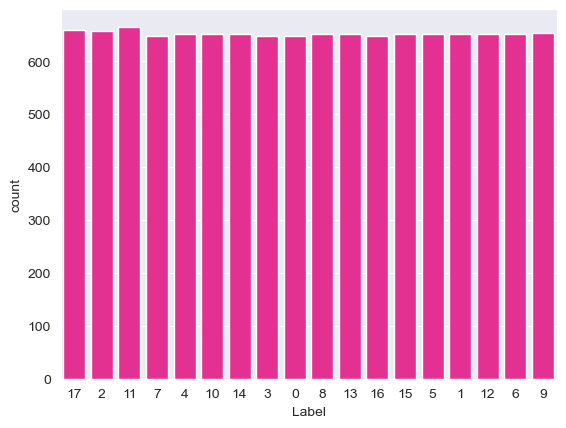

In [102]:
sns.countplot(images_df, x = 'Label', color = 'deeppink');

<h3><center>Podział danych na treningowe oraz testowe i stworzenie obiektu DataGenerator dla zdjęć</center></h3>
<span style="font-size:15px">Podział danych jest dość standardowy, 80% jako zbiór treningowy i 20% jako zbiór walidacyjny. Obiekty ImageDataGenerator służą przetworzeniu zdjęć (jeszcze dogłębniej niż zostało już to zrobione na początku w zbiorze), aby upewnić się, że model dobrze się nauczy i nie przeuczy. Następnie w obiektach train/validate_iterator dobierane są parametry dotyczące już bardziej samego procesu uczenia takie jak np. rozmiar wejściowy zdjęcia czy też ilość zdjęć na któych sieć będzie się uczyć podczas jedenej iteracji.

In [103]:
train, validate = train_test_split(images_df, test_size = 0.2, random_state = 42)

train_generator = ImageDataGenerator(
    rescale = 1./255,  # normalization of images
    rotation_range = 40, # augmentation of images to avoid overfitting
    shear_range = 0.2,  
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

validate_generator = ImageDataGenerator(rescale = 1./255)

train_iterator = train_generator.flow_from_dataframe(
    train, 
    x_col = 'Images', 
    y_col = 'Label', 
    target_size = (256, 256), 
    batch_size = 64, 
    class_mode = 'categorical'
)

validate_iterator = validate_generator.flow_from_dataframe(
    validate, 
    x_col = 'Images', 
    y_col = 'Label', 
    target_size = (256, 256), 
    batch_size = 64, 
    class_mode = 'categorical'
)

Found 9389 validated image filenames belonging to 18 classes.
Found 2348 validated image filenames belonging to 18 classes.


<h3><center>Tworzenie i trening modelu</center></h3>
<span style="font-size:15px">Model skałda się z warstwy konwolucyjnej oraz warstwy spoolingu (redukjącej wymiary danych o połowę) przeplatających się wzajemnie trzy razy. Warstwy wyjściowe to w kolejności: flatten (przekształca dane wielowymiarowe z wyjścia warstw konwolucyjnych i spooling'u na jednowymiarowy wektor) oraz dense (warstwa gęsta posiadająca 18 neuronów, odpowiadających liczbie klas). Trening poniższej sieci zajął 56 minut na GPU Nvidia Geforce RTX 3050 Ti, co jak na jej złożoność nie jest najgorszym wynikiem.

In [104]:
model = Sequential([
                    Conv2D(16, (3, 3), activation = 'relu', input_shape = (256, 256, 3)),
                    MaxPool2D((2, 2)),
                    Conv2D(32, (3, 3), activation = 'relu'),
                    MaxPool2D((2, 2)),
                    Conv2D(64, (3, 3), activation = 'relu'),
                    MaxPool2D((2, 2)),
                    Flatten(),
                    Dense(256, activation = 'relu'),
                    Dense(18, activation = 'softmax')
])

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 127, 127, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 30, 30, 64)      

In [105]:
sess = tf.compat.v1.Session(config = tf.compat.v1.ConfigProto(log_device_placement=True))
history = model.fit(train_iterator, epochs = 20, validation_data = validate_iterator)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
Epoch 1/20
147/147 [==============================] - 172s 1s/step - loss: 2.8557 - accuracy: 0.1240 - val_loss: 2.6319 - val_accuracy: 0.1997
Epoch 2/20
147/147 [==============================] - 168s 1s/step - loss: 2.3657 - accuracy: 0.2698 - val_loss: 2.3954 - val_accuracy: 0.2811
Epoch 3/20
147/147 [==============================] - 174s 1s/step - loss: 2.0499 - accuracy: 0.3684 - val_loss: 2.0267 - val_accuracy: 0.3876
Epoch 4/20
147/147 [==============================] - 169s 1s/step - loss: 1.8192 - accuracy: 0.4457 - val_loss: 1.8472 - val_accuracy: 0.4506
Epoch 5/20
147/147 [==============================] - 169s 1s/step - loss: 1.6341 - accuracy: 0.5042 - val_loss: 1.7989 - val_accuracy: 0.4689
Epoch 6/20
147/147 [==============================] - 177s 1s/step - loss: 1.4820 - accuracy: 0.5533 - val_loss: 1.

<h3><center>Zapis modelu i histori treingu</center></h3>
<span style="font-size:15px">Trening CNN jest dość czasochłonny, dlatego poniższy kod dokonuje zapisu wytrenowanego modelu i histori jego uczenia.

In [106]:
model.save('op_model/op_model256_64_20.h5')
with open('op_model_history/op_model_256_64_20_history', 'wb') as file:
    pickle.dump(history.history, file)

<h3><center>Wizualizacja wartości dokładności i straty w trakcie uczenia modelów</center></h3>
<span style="font-size:15px">Na poniższych wykresach znajduje się wizualizacja wartości accuracy oraz loss dla poszczególnych CNN. Liczby w nazwie modelu oznaczają po kolei: target_size, batch_size, ilość epok. Na podstawie wyników wykresów, łatwo stwierdzić, że najlepsze wyniki osiągnęła sieć z wartościami 256, 64 i 20 (accuracy: 82%, val_accuracy: 63%, loss: 0.58, val_loss: 1.53), dlatego to ona została wybrana do testów zawartych w dalszej części notatnika. Minusem powyższej CNN był natomiast najdłuższy ze wszystkich czas treningu. 

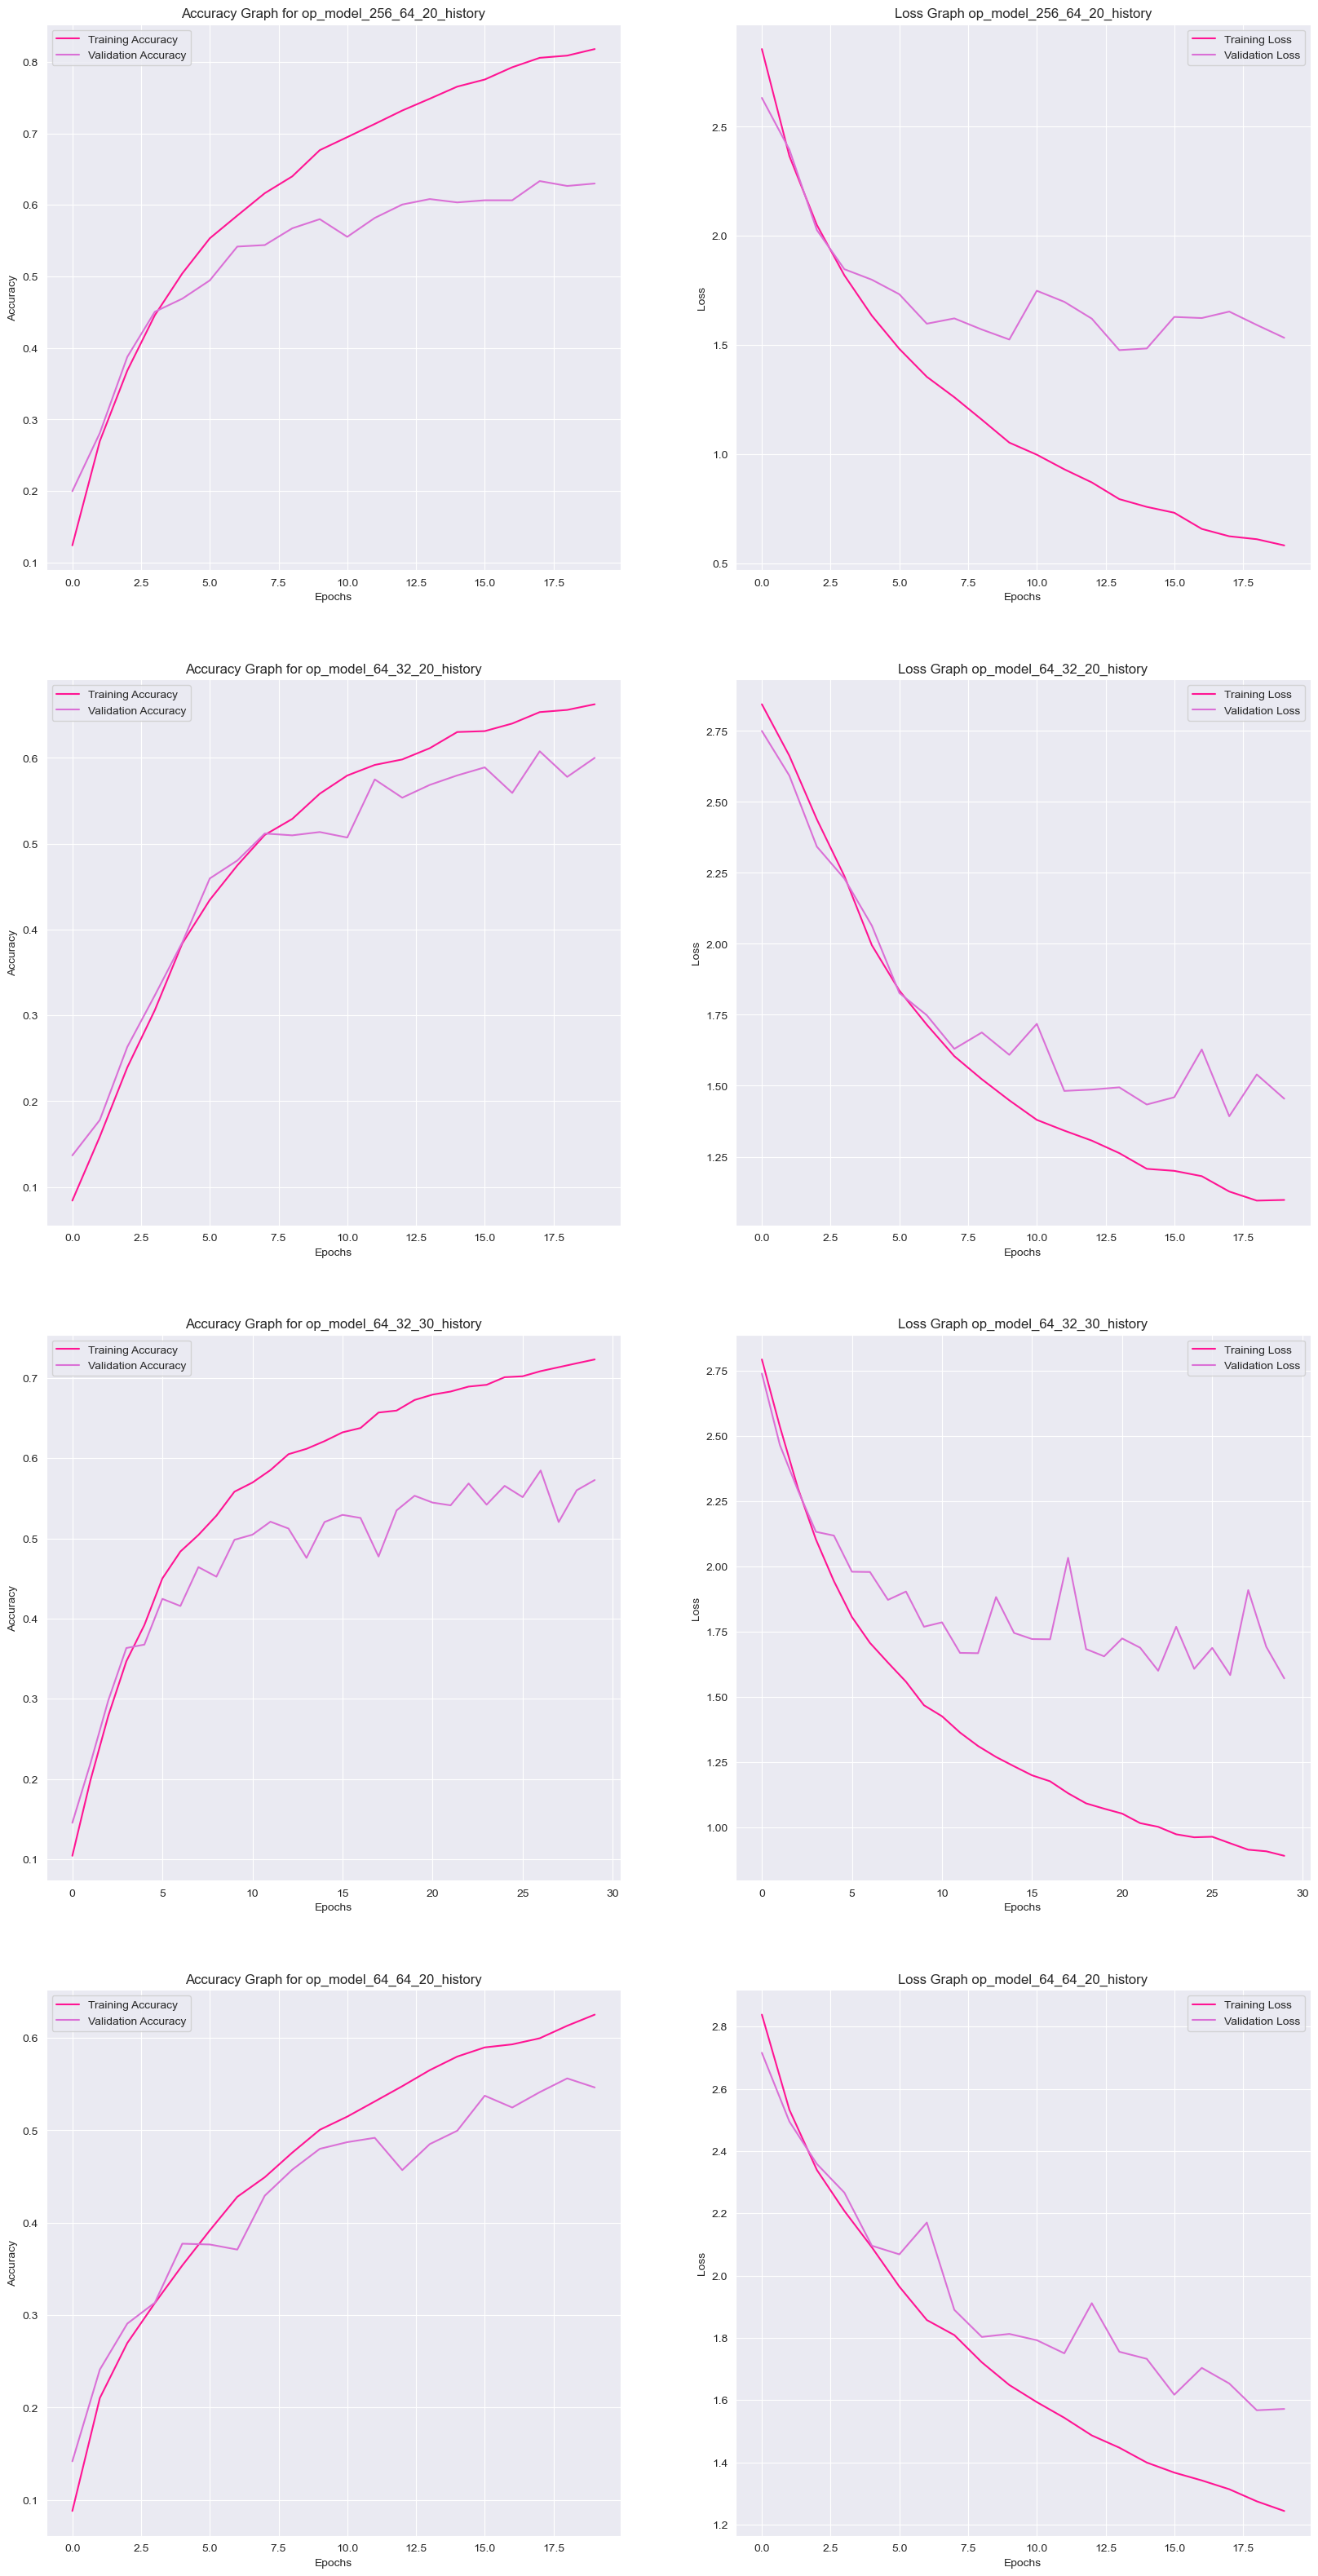

In [107]:
fig, ax = plt.subplots(4, 2, figsize=(20, 40))

i = 0
for file in os.listdir('op_model_history/'):
    with open(os.path.join('op_model_history', file), 'rb') as file_pi:
        history = pickle.load(file_pi)
    accuracy = history['accuracy']
    val_accuracy = history['val_accuracy']
    epochs = range(len(accuracy))
    
    ax[i, 0].plot(epochs, accuracy, 'deeppink', label = 'Training Accuracy')
    ax[i, 0].plot(epochs, val_accuracy, 'orchid', label = 'Validation Accuracy')
    ax[i, 0].set_title('Accuracy Graph for ' + file)
    ax[i, 0].set_xlabel('Epochs')
    ax[i, 0].set_ylabel('Accuracy')
    ax[i, 0].legend()
    
    loss = history['loss']
    val_loss = history['val_loss']
    ax[i, 1].plot(epochs, loss, 'deeppink', label = 'Training Loss')
    ax[i, 1].plot(epochs, val_loss, 'orchid', label = 'Validation Loss')
    ax[i, 1].set_title('Loss Graph ' + file)
    ax[i, 1].set_xlabel('Epochs')
    ax[i, 1].set_ylabel('Loss')
    ax[i, 1].legend()
    i += 1

<h3><center>Przykładowe predykcje na zdjęciach z internetu nie zawartych w danych treningowych</center></h3>
<span style="font-size:15px">Wytrenowana sieć radzi sobie w miarę dobrze, jeśli chodzi o klasyfikację, co widać na poniższych przykładach.

1/1 [==============================] - 0s 24ms/step
Predicted character is a: Ace


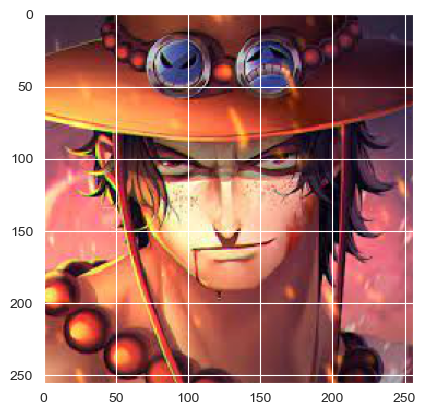

In [138]:
image_path = "ace.jpg"
img = load_img(image_path, target_size = (256, 256))
img = np.array(img)
img = img / 255.0
plt.imshow(img)
img = img.reshape(1, 256, 256, 3) # reshape for prediction
pred = model.predict(img)
print('Predicted character is a: ' + str(list(label_map.keys())[list(label_map.values()).index(pred.argmax())]))

1/1 [==============================] - 0s 23ms/step
Predicted character is a: Akainu


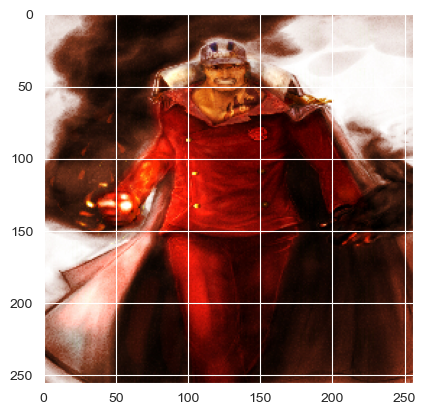

In [139]:
image_path = "akainu.jpg"
img = load_img(image_path, target_size = (256, 256))
img = np.array(img)
img = img / 255.0
plt.imshow(img)
img = img.reshape(1, 256, 256, 3) # reshape for prediction
pred = model.predict(img)
print('Predicted character is a: ' + str(list(label_map.keys())[list(label_map.values()).index(pred.argmax())]))